In [1]:
import sys
import pathlib
sys.path.insert(0, str(pathlib.Path("").resolve().parent)) #.. this has to be the folder reCNN_visual_prosthesis
import wandb
import glob
import pytorch_lightning as pl
from models import reCNN_bottleneck_CyclicGauss3d
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torchvision.transforms as transforms
import math
from Antolik_dataset import AntolikDataset, AntolikDataModule
from experiments.utils import pickle_read, download_model, get_neuron_estimates, reconstruct_orientation_maps, visualize_preferred_orientations, rotate_and_compute_distances, circular_distance
import pickle
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch
from neuralpredictors.data.samplers import SubsetSequentialSampler
from typing import Optional
import pathlib
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import math
from experiments.utils import pickle_read
from Antolik_dataset import AntolikDataModule

In [2]:
ENTITY = "csng-cuni"
PROJECT = "reCNN_visual_prosthesis"
ground_truth_positions_file_path = "data/antolik/position_dictionary.pickle"
ground_truth_orientations_file_path = "data/antolik/oris.pickle"

model = None

config = {
    # GENERAL
    "seed": 2,
    "batch_size": 10,
    "lr": 0.01,
    "max_epochs": 80,

    # CORE GENERAL CONFIG
    "core_hidden_channels": 8,
    "core_layers": 5,
    "core_input_kern": 9,
    "core_hidden_kern": 9,

    # ROTATION EQUIVARIANCE CORE CONFIG
    "num_rotations": 8,       
    "stride": 1,               
    "upsampling": 2,           
    "rot_eq_batch_norm": True, 
    "stack": -1 ,               
    "depth_separable": True,

    # READOUT CONFIG
    "readout_bias": True, ###################################################### TODOOOOOOOOOOOOOOOOOOO
    "nonlinearity": "softplus",
    
    # REGULARIZATION
    "core_gamma_input": 0.00307424496692959,
    "core_gamma_hidden": 0.28463619129195233,
    "readout_gamma": 0.17,
    "input_regularizer": "LaplaceL2norm", # for RotEqCore - default 
    "use_avg_reg": True,

    "reg_readout_spatial_smoothness": 0.0027,
    "reg_group_sparsity": 0.1,
    "reg_spatial_sparsity": 0.45,

    # TRAINER
    "patience": 7,
    "train_on_val": False, # in case you want to quickly check that your model "compiles" correctly
    "test": True,
    "observed_val_metric": "val/corr",

    "test_average_batch": False,
    "compute_oracle_fraction": False,
    "conservative_oracle": True,
    "jackknife_oracle": True,
    "generate_oracle_figure": False,

    # ANTOLIK
    "region": "region1",
    "dataset_artifact_name": "Antolik_dataset:latest",

    # BOTTLENECK
    "bottleneck_kernel": 15,

    "fixed_sigma": False,
    "init_mu_range": 0.5,
    "init_sigma_range": 0.5,
    "ground_truth_positions_file_path": "data/antolik/positions_reparametrized.pickle",
    "ground_truth_orientations_file_path": "data/antolik/oris_reparametrized.pickle",
}

path_train = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik_reparametrized/one_trials.pickle"
path_test = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik_reparametrized/ten_trials.pickle"

dataset_config = {
    
    "train_data_dir": path_test,
    "test_data_dir": path_test,
    "batch_size": config["batch_size"],
    "normalize": True,
    "val_size": 500,
    "brain_crop": None,
    "stimulus_crop": None,
    # "brain_crop": 1.5,
    # "stimulus_crop": "auto",
    # "stimulus_crop": [80, 80],
    "ground_truth_positions_file_path": config["ground_truth_positions_file_path"],
}

dm = AntolikDataModule(**dataset_config)

In [3]:
dm.prepare_data()
dm.setup()

Data loaded successfully!


In [4]:
dm.get_output_shape()

torch.Size([5000])

In [5]:
dm.get_input_shape()


torch.Size([1, 110, 110])

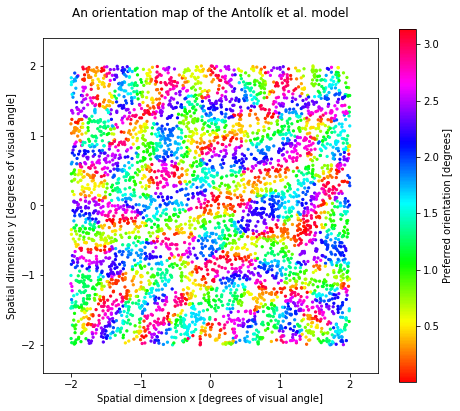

In [6]:
dm.visualize_orientation_map(config["ground_truth_positions_file_path"], config["ground_truth_orientations_file_path"])

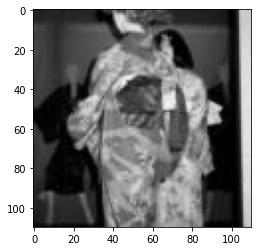

In [7]:
dm.train_dataset.visualize(0)

In [8]:
print(dm.get_stimulus_visual_angle())

11


In [9]:
config.update(
        {
            "input_channels": dm.get_input_shape()[0],
            "input_size_x": dm.get_input_shape()[1],
            "input_size_y": dm.get_input_shape()[2],
            "num_neurons": dm.get_output_shape()[0],
            "mean_activity": dm.get_mean(),
            "filtered_neurons":dm.get_filtered_neurons(),
        }
    )

Loaded precomputed mean from /storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik_reparametrized/ten_trials_mean.npy


In [10]:
config.update(
    {
        "init_to_ground_truth_positions": False,
        "init_to_ground_truth_orientations": False,
        "freeze_positions": False,
        "freeze_orientations": False,
        "orientation_shift": 87.4,
        "factor": 5.5,
        "sample": False,
        "filtered_neurons":None,
    }
)

In [11]:
early_stopping_monitor="val/corr"
early_stopping_mode="max"
model_checkpoint_monitor="val/corr"
model_checkpoint_mode="max"

use_wandb = True

from models import reCNN_bottleneck_CyclicGauss3d

model_artifact_name = None
needs_ground_truth = False
model_needs_dataloader = False
model_class = reCNN_bottleneck_CyclicGauss3d

if needs_ground_truth:
    pos_x, pos_y, orientations = dm.get_ground_truth(config["ground_truth_positions_file_path"], config["ground_truth_orientations_file_path"])
    resolution = (dm.get_input_shape()[1], dm.get_input_shape()[2])
    xlim = [-dm.get_stimulus_visual_angle()/2, dm.get_stimulus_visual_angle()/2]
    ylim = [-dm.get_stimulus_visual_angle()/2, dm.get_stimulus_visual_angle()/2]
    model = model_class(pos_x, pos_y, orientations, resolution, xlim, ylim, **config)
elif model_needs_dataloader:
    model = model_class(dm, **config)
else:
    model = model_class(**config)

/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")
/opt/conda/lib/python3.8/site-packages/neuralpredictors/layers/cores/conv2d.py:128: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/auto/budejovice1/mpicek/reCNN_visual_prosthesis/readout.py:173: UserWarning: sigma is sampled from uniform distribuiton, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(


In [12]:
import wandb
from Lurz_dataset import LurzDataModule

from models import reCNN_FullFactorized
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.progress import ProgressBar
import pytorch_lightning as pl
from models import reCNN_bottleneck_CyclicGauss3d
from pprint import pprint
from Antolik_dataset import AntolikDataModule

if use_wandb:

    pl.seed_everything(config["seed"], workers=True)    

    # init wandb run
    run = wandb.init(
        config=config,
        project=PROJECT,
        entity=ENTITY,
    )

    # Access all hyperparameter values through wandb.config
    config = dict(wandb.config)
    pprint(config)


    # setup wandb logger
    wandb_logger = WandbLogger(log_model=True)
    wandb_logger.watch(model, log="parameters", log_freq=250)

    # define callbacks for the training
    early_stop = EarlyStopping(
        monitor=early_stopping_monitor,
        patience=config["patience"],
        mode=early_stopping_mode,
    )
    checkpoint_callback = ModelCheckpoint(
        save_top_k=1, monitor=model_checkpoint_monitor, mode=model_checkpoint_mode
    )

    class LitProgressBar(ProgressBar):
        def get_metrics(self, trainer, model):
            # don't show the version number
            items = super().get_metrics(trainer, model)
            items.pop("v_num", None)
            return items

    bar = LitProgressBar()


    # define the trainer
    trainer = pl.Trainer(
        callbacks=[early_stop, checkpoint_callback, bar],
        max_epochs=config["max_epochs"],
        # max_epochs=1,
        gpus=[0],
        logger=wandb_logger,
        log_every_n_steps=250,
        # deterministic=True,
        enable_checkpointing=True,
    )


    trainer.fit(
        model,
        train_dataloaders=dm.train_dataloader(),
        val_dataloaders=dm.val_dataloader(),
        )

    best_observed_val_metric = (
        checkpoint_callback.best_model_score.cpu().detach().numpy()
    )
    print(
        "Best model's "
        + config["observed_val_metric"]
        + ": "
        + str(best_observed_val_metric)
    )

    if model_artifact_name == None:
        model_artifact_name = model.__str__()
    
    print(model_artifact_name)
    print(model_artifact_name)

    # add best corr to metadata
    metadata = {**config, "best_model_score": best_observed_val_metric}

    # add model artifact
    best_model_artifact = wandb.Artifact(
        model_artifact_name, type="model", metadata=metadata
    )
    print(best_model_artifact)
    print(best_model_artifact)
    best_model_artifact.add_file(checkpoint_callback.best_model_path)
    run.log_artifact(best_model_artifact)

    # say to wandb that the best val/corr of the model is the best one
    # and not the last one!! (it is the default behavour!!)
    run.summary[config["observed_val_metric"]] = best_observed_val_metric

    print(checkpoint_callback.best_model_path)

    model = model_class.load_from_checkpoint(checkpoint_callback.best_model_path)

    if config["test"]:
        dm.model_performances(model, trainer)



        # result_artifact = wandb.Artifact(name="RESULT_" + model_artifact_name, type="result",
        #     metadata=results[0])
        # run.log_artifact(result_artifact)

else:
    pl.seed_everything(config["seed"], workers=True)
    pprint(config)


    # define callbacks for the training
    early_stop = EarlyStopping(
        monitor=early_stopping_monitor,
        patience=config["patience"],
        mode=early_stopping_mode,
    )
    checkpoint_callback = ModelCheckpoint(
        save_top_k=1, monitor=model_checkpoint_monitor, mode=model_checkpoint_mode
    )

    class LitProgressBar(ProgressBar):
        def get_metrics(self, trainer, model):
            # don't show the version number
            items = super().get_metrics(trainer, model)
            items.pop("v_num", None)
            return items

    bar = LitProgressBar()

    # define the trainer
    trainer = pl.Trainer(
        callbacks=[early_stop, checkpoint_callback, bar],
        max_epochs=config["max_epochs"],
        gpus=[0],
        # logger=wandb_logger,
        log_every_n_steps=1,
        # deterministic=True,
        enable_checkpointing=True,
    )

    if config["train_on_val"]:
        trainer.fit(
            model,
            train_dataloaders=dm.val_dataloader(),
            val_dataloaders=dm.val_dataloader(),
        )

    else:
        trainer.fit(
            model,
            train_dataloaders=dm.train_dataloader(),
            val_dataloaders=dm.val_dataloader(),
        )

    best_observed_val_metric = (
        checkpoint_callback.best_model_score.cpu().detach().numpy()
    )
    print(
        "Best model's "
        + config["observed_val_metric"]
        + ": "
        + str(best_observed_val_metric)
    )

    # add best corr to metadata
    metadata = {**config, "best_model_score": best_observed_val_metric}

    print(checkpoint_callback.best_model_path)

    model = model_class.load_from_checkpoint(checkpoint_callback.best_model_path)

    if config["test"]:
        dm.model_performances(model, trainer)

        # result_artifact = wandb.Artifact(name="RESULT_" + model_artifact_name, type="result",
        #     metadata=results[0])
        # run.log_artifact(result_artifact)

Global seed set to 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: csng-cuni (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/opt/conda/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:341: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/callbacks/progress/progress.py:21: LightningDeprecationWarning: `ProgressBar` has been deprecated in v1.5 and will be removed in v1.7. It has been renamed to `TQDMProgressBar` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


{'batch_size': 10,
 'bottleneck_kernel': 15,
 'compute_oracle_fraction': False,
 'conservative_oracle': True,
 'core_gamma_hidden': 0.28463619129195233,
 'core_gamma_input': 0.00307424496692959,
 'core_hidden_channels': 8,
 'core_hidden_kern': 9,
 'core_input_kern': 9,
 'core_layers': 5,
 'dataset_artifact_name': 'Antolik_dataset:latest',
 'depth_separable': True,
 'factor': 5.5,
 'filtered_neurons': None,
 'fixed_sigma': False,
 'freeze_orientations': False,
 'freeze_positions': False,
 'generate_oracle_figure': False,
 'ground_truth_orientations_file_path': 'data/antolik/oris_reparametrized.pickle',
 'ground_truth_positions_file_path': 'data/antolik/positions_reparametrized.pickle',
 'init_mu_range': 0.5,
 'init_sigma_range': 0.5,
 'init_to_ground_truth_orientations': False,
 'init_to_ground_truth_positions': False,
 'input_channels': 1,
 'input_regularizer': 'LaplaceL2norm',
 'input_size_x': 110,
 'input_size_y': 110,
 'jackknife_oracle': True,
 'lr': 0.01,
 'max_epochs': 80,
 'mean

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-580127a3-0eba-841c-18f8-9dc54acd6abc]

  | Name    | Type                                | Params
----------------------------------------------------------------
0 | loss    | PoissonLoss                         | 0     
1 | corr    | Corr                                | 0     
2 | core    | RotationEquivariant2dCoreBottleneck | 477 K 
3 | readout | Gaussian3dCyclic                    | 40.0 K
4 | nonlin  | Softplus                            | 0     
----------------------------------------------------------------
140 K     Trainable params
377 K     Non-trainable params
517 K     Total params
2.070     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:452: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Global seed set to 2
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 34: 100%|██████████| 500/500 [02:30<00:00,  3.32it/s, loss=-1.01] 
Best model's val/corr: 0.14223294
reCNN_bottleneck_CyclicGauss3d
reCNN_bottleneck_CyclicGauss3d
/auto/budejovice1/mpicek/reCNN_visual_prosthesis/reCNN_visual_prosthesis/11sswdhq/checkpoints/epoch=27-step=12599.ckpt


/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")
/opt/conda/lib/python3.8/site-packages/neuralpredictors/layers/cores/conv2d.py:128: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/auto/budejovice1/mpicek/reCNN_visual_prosthesis/readout.py:173: UserWarning: sigma is sampled from uniform distribuiton, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-580127a3-0eba-841c-18f8-9dc54acd6abc]
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:452: UserWarning: Your `test_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_ze

Testing: 100%|██████████| 50/50 [00:05<00:00,  9.08it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-580127a3-0eba-841c-18f8-9dc54acd6abc]



Testing: 100%|██████████| 500/500 [00:55<00:00,  9.06it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-580127a3-0eba-841c-18f8-9dc54acd6abc]


Testing: 100%|██████████| 500/500 [00:05<00:00, 95.64it/s] 
Validation dataset:
    Correlation: 0.1422 
Test dataset with averaged responses of repeated trials:
    Correlation: 0.1449 
    Fraction oracle conservative: 0.1449 
    Fraction oracle jackknife: 0.1449 


In [13]:
import sys
import pathlib
sys.path.insert(0, str(pathlib.Path("").resolve().parent)) #.. this has to be the folder reCNN_visual_prosthesis
import wandb
import glob
import pytorch_lightning as pl
from models import reCNN_bottleneck_CyclicGauss3d
import matplotlib.pyplot as plt
import numpy as np
import pickle
from experiments.utils import pickle_read, download_model, get_neuron_estimates, reconstruct_orientation_maps, visualize_preferred_orientations, rotate_and_compute_distances, circular_distance

In [14]:
save = False

plt.rcParams.update({'font.size': 12})
factor = 5.5
img_path = "img/"

In [15]:
# m = download_model(artifact_name="csng-cuni/reCNN_visual_prosthesis/model-25vncyv8:v0", model_class=model_class)
m = model


The average distance error in x is 2.9340484366560906
The average distance error in y is 2.917369312128594
The average distance error is 4.539803616422596


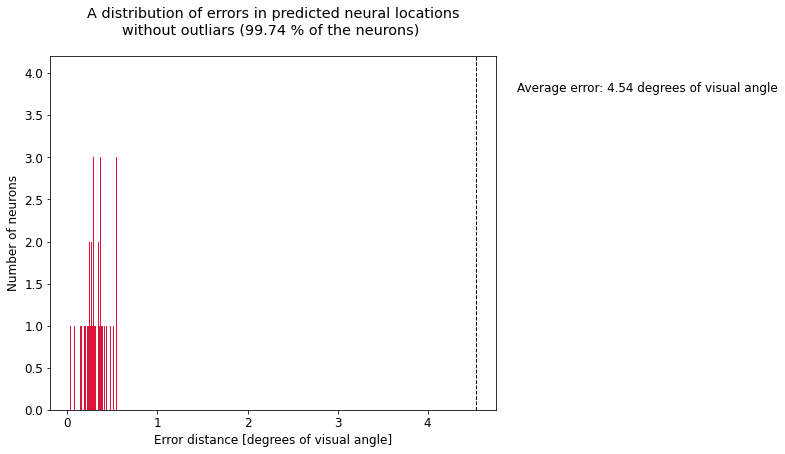

<Figure size 432x288 with 0 Axes>

In [16]:
x, y, ori = get_neuron_estimates(m, factor)

#####################################################################################
################################## Position errors ##################################
#####################################################################################
# get the target values (values from the Antolik's computational model)
pos_dict = pickle_read("data/antolik/position_dictionary.pickle")
target_positions = np.concatenate([pos_dict['V1_Exc_L2/3'].T, pos_dict['V1_Inh_L2/3'].T])
o_dict = pickle_read("data/antolik/oris.pickle")
target_ori = np.concatenate([np.array(o_dict['V1_Exc_L2/3']), np.array(o_dict['V1_Inh_L2/3'])])

n_neurons = dm.get_output_shape()[0]

# measure the errors in positions 
s_x = np.zeros((n_neurons))
s_y = np.zeros((n_neurons))
for i in range(n_neurons):
    s_x[i] = abs(x[i] - target_positions[i][0])
    s_y[i] = abs(y[i] + target_positions[i][1]) # it is upside down

avg_x = np.sum(s_x)/n_neurons
avg_y = np.sum(s_y)/n_neurons

distances = np.sqrt(s_x**2 + s_y**2)

print(f"The average distance error in x is {avg_x}")
print(f"The average distance error in y is {avg_y}")
print(f"The average distance error is {np.sum(distances)/n_neurons}")

avg_error = np.mean(distances)
distances = [x for x in distances if x < 0.1 * factor] # delete outliers

# and finally plot the distribution of distance errors
plt.gcf().set_size_inches(8, 6.5)
plt.hist(distances, bins=100, color="crimson")
plt.axvline(avg_error, color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(avg_error*1.1, max_ylim*0.9, 'Average error: {:.2f} degrees of visual angle'.format(avg_error))
plt.title("A distribution of errors in predicted neural locations\nwithout outliars ({:.2f} % of the neurons) \n".format((1 - len(distances)/30000) * 100))
plt.xlabel("Error distance [degrees of visual angle]")
plt.ylabel("Number of neurons")
if save:
    plt.savefig(img_path + "distribution_of_distances_errors", dpi = 300)
    print("saved")
plt.show()
plt.clf()

Average orientation error:
44.47522830018347
Shift:
169.71428571428572


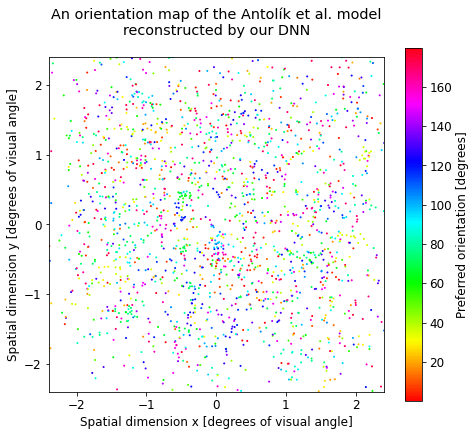

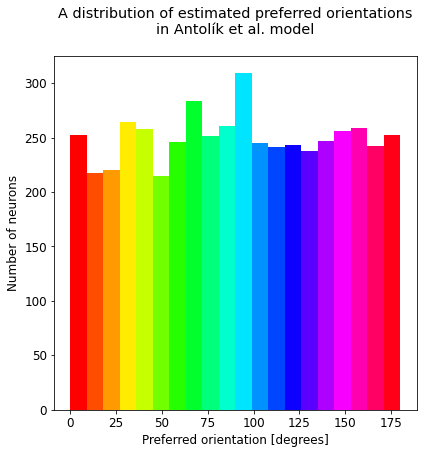

<Figure size 432x288 with 0 Axes>

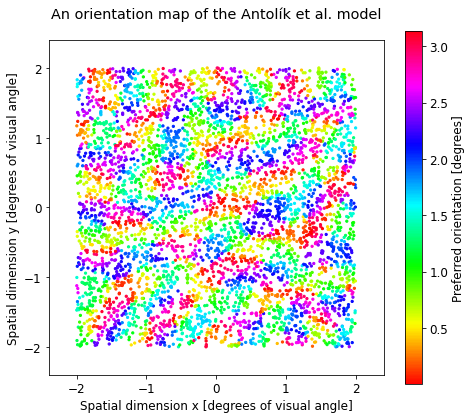

In [17]:
#####################################################################################
############################### Orientation errors ##################################
#####################################################################################

predicted_ori = np.array(ori)  # [0, 1]
predicted_ori = 180 * predicted_ori # [0, 180]
target_ori = 180 * target_ori / np.pi # from [0, pi] to [0, 180]

result = rotate_and_compute_distances(predicted_ori, target_ori, period=180, n_rot=36)


f, ax = plt.subplots()

print("Average orientation error:")
print(result[0][np.argmin(result[0])])

print("Shift:")
print(result[1][np.argmin(result[0])])
shift = result[1][np.argmin(result[0])]

distances = circular_distance(((predicted_ori + shift) % 180), target_ori, 180) 

# we align the predicted orientations with the ground truth rotations (to have the same shift)
predicted_ori_aligned = (predicted_ori + shift) % 180 
reconstruct_orientation_maps(x, y, predicted_ori_aligned, f, ax, save, 12, 2.4, 2.4, img_path, "_antolik")
visualize_preferred_orientations(x, y, predicted_ori_aligned, f, ax, save, 12, 2.4, 2.4, img_path, "_antolik")

dm.visualize_orientation_map(config["ground_truth_positions_file_path"], config["ground_truth_orientations_file_path"])
